# 🧠 Resume–Job Embedding Evaluation
Unsupervised evaluation of how well resume and job embeddings align semantically.

In [1]:

import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


## 1. Load Embeddings

In [2]:

EMB_DIR = os.path.join('..', 'data', 'embeddings')
resume_embeddings = np.load(os.path.join(EMB_DIR, 'resume_embeddings.npy'))
job_embeddings = np.load(os.path.join(EMB_DIR, 'job_embeddings.npy'))


## 2. Combine and Prepare Data

In [3]:

combined_embeddings = np.vstack([resume_embeddings, job_embeddings])
labels = np.array(['resume']*len(resume_embeddings) + ['job']*len(job_embeddings))


## 3. Run KMeans Clustering

In [4]:

n_clusters = 10  # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(combined_embeddings)


## 4. Compute Cluster Metrics

In [5]:

silhouette = silhouette_score(combined_embeddings, cluster_labels)
calinski = calinski_harabasz_score(combined_embeddings, cluster_labels)
davies = davies_bouldin_score(combined_embeddings, cluster_labels)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski–Harabasz Index: {calinski:.3f}")
print(f"Davies–Bouldin Index: {davies:.3f}")


Silhouette Score: 0.059
Calinski–Harabasz Index: 302.254
Davies–Bouldin Index: 3.272


## 5. Cluster Composition (Resume–Job Mixing)

In [6]:

cluster_df = pd.DataFrame({'cluster': cluster_labels, 'type': labels})
cluster_mix = cluster_df.groupby('cluster')['type'].nunique().mean()
print(f"Average Cluster Diversity (1.0 = resumes and jobs co-exist): {cluster_mix:.3f}")


Average Cluster Diversity (1.0 = resumes and jobs co-exist): 2.000


## 6. Cosine Similarity Evaluation

In [7]:

sample_jobs = job_embeddings[np.random.choice(len(job_embeddings), size=min(200, len(job_embeddings)), replace=False)]
sim_matrix = cosine_similarity(sample_jobs, resume_embeddings)
avg_max_sim = sim_matrix.max(axis=1).mean()
avg_mean_sim = sim_matrix.mean(axis=1).mean()

print(f"Average Max Resume–Job Similarity: {avg_max_sim:.3f}")
print(f"Average Mean Resume–Job Similarity: {avg_mean_sim:.3f}")


Average Max Resume–Job Similarity: 0.732
Average Mean Resume–Job Similarity: 0.479


## 7. Visualize Clusters with PCA

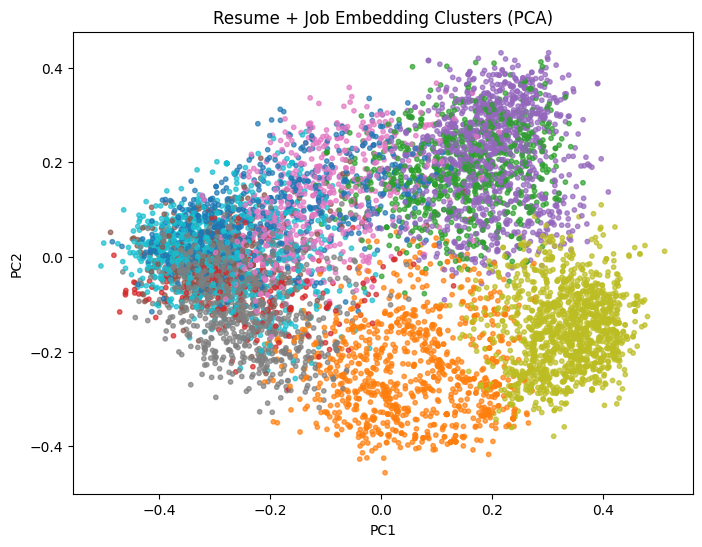

In [8]:

reduced = PCA(n_components=2, random_state=42).fit_transform(combined_embeddings)
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=cluster_labels, cmap='tab10', s=10, alpha=0.7)
plt.title('Resume + Job Embedding Clusters (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## 8. Visualize Resume vs Job Distribution

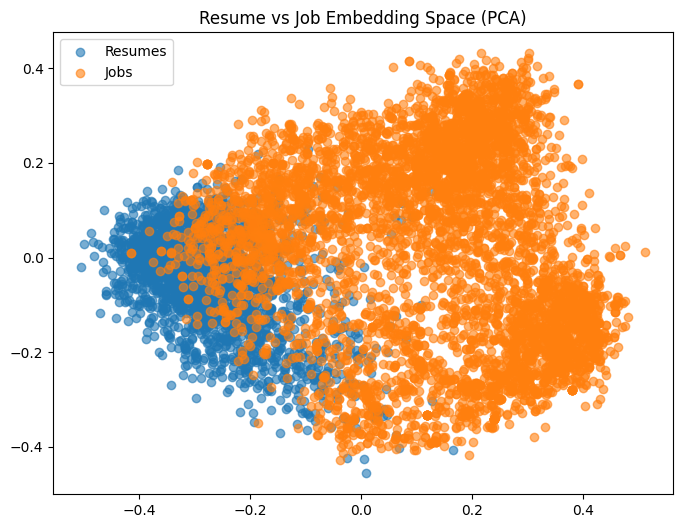

In [9]:

plt.figure(figsize=(8,6))
plt.scatter(reduced[labels=='resume',0], reduced[labels=='resume',1], label='Resumes', alpha=0.6)
plt.scatter(reduced[labels=='job',0], reduced[labels=='job',1], label='Jobs', alpha=0.6)
plt.legend()
plt.title('Resume vs Job Embedding Space (PCA)')
plt.show()


## 9. Optional: View Sample Matches

In [10]:

try:
    resume_df = pd.read_csv(os.path.join('..', 'data', 'resumes_cleaned.csv'))
    job_df = pd.read_csv(os.path.join('..', 'data', 'jobs_cleaned.csv'))
    print("\nTop Resume–Job Matches:")
    for i in range(3):
        j_idx = np.argmax(sim_matrix[i])
        print(f"Job {i} → Resume {j_idx} | Similarity: {sim_matrix[i, j_idx]:.3f}")
        print("JOB TEXT:", job_df.iloc[i]['job_text_clean'][:250], '...')
        print("RESUME TEXT:", resume_df.iloc[j_idx]['Resume_clean'][:250], '...')
        print('-'*100)
except Exception as e:
    print("(Skipped text inspection because job/resume CSVs not found)")



Top Resume–Job Matches:
Job 0 → Resume 134 | Similarity: 0.712
JOB TEXT: description secretary office helper typing transition english armenian able speck understand english armenian russian answer phone make call arrange appointment answering door welcoming customer requirement take care office time work supervision self ...
RESUME TEXT: vr designer summary game designer exceptional modeling prioritization skill looking career organization would enhance skillset experience vr designer company name city state help facilitate process game development using unity virtual reality boeing  ...
----------------------------------------------------------------------------------------------------
Job 1 → Resume 2475 | Similarity: 0.728
JOB TEXT: description keeping complete accounting company requirement bookkeeping financial planning department management qualification education accounting must minium year cheif accountant production company must familiar international accounting norm highl .

## 10. Summary

In [11]:

print("\n--- Evaluation Summary ---")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski–Harabasz Index: {calinski:.3f}")
print(f"Davies–Bouldin Index: {davies:.3f}")
print(f"Cluster Diversity: {cluster_mix:.3f}")
print(f"Average Max Resume–Job Similarity: {avg_max_sim:.3f}")



--- Evaluation Summary ---
Silhouette Score: 0.059
Calinski–Harabasz Index: 302.254
Davies–Bouldin Index: 3.272
Cluster Diversity: 2.000
Average Max Resume–Job Similarity: 0.732
